In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from forecasters import feature_factory as ff
from forecasters import boosted_hybrid as bh

In [129]:
import importlib
importlib.reload(ff)
importlib.reload(bh)

<module 'forecasters.boosted_hybrid' from '/home/shem/repos/eforecast/forecasters/boosted_hybrid.py'>

In [35]:
df_daily = pd.read_csv("test_data/df_daily_test_data.csv", parse_dates=["ts"], 
                       index_col=["ts"]).rename(columns={"energy_kWh": "y"})

In [23]:
df_daily.head(3)

,y
ts,
2012-06-21,3.730
2012-06-22,4.400
2012-06-23,4.965


In [58]:
factory = ff.FeatureFactory(df_daily)

In [25]:
X_trend = factory.create_time_trend_features(order=1)

Creating time trend features of order: 1


In [59]:
X_lag = factory.create_lag_features(lag_steps=1)

Creating lag features of lag: 1


In [27]:
X_seasonal = factory.create_fourier_features(freq="y", fourier_order=12)

Creating seasonal features for Fourier freq: y and Fourier order: 12


In [67]:
X_statistical = factory.create_statistical_features(mean_window=7, median_window=7, stdev_window=7)

Creating rolling window statistical features of mean_7, median_7, stdev7


In [103]:
# add the target y so we can drop nans across rows
X_all = factory.combine_features([X_trend, X_lag, X_statistical, X_seasonal, df_daily.y])

## Train lin reg model and plot results
 - Here just testing self predict (same training and prediction data)

In [104]:
# Drop NaNs and set up the X and y dfs

X_all = X_all.dropna(axis=0)

X = X_all.drop(columns=["y"])
y = X_all.y

# Train model
model = LinearRegression()
model.fit(X, y)

# Store fitted values a new time series
y_pred = pd.Series(model.predict(X), index=X.index)

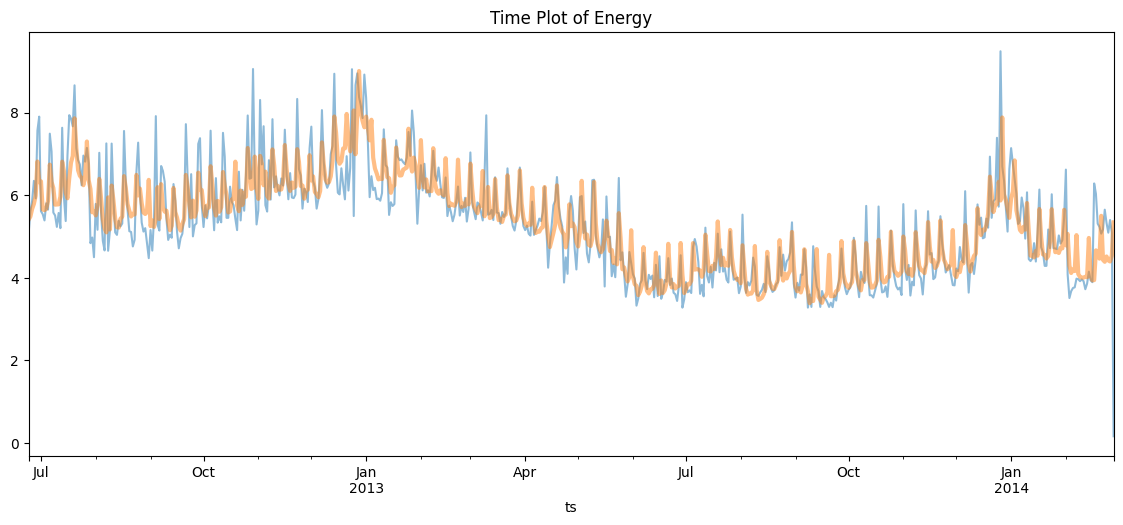

score: 0.7471382933019932
coeff: [ 8.38909584e-15 -3.40802520e-03  3.03649764e-01 -1.30723148e-01
  1.52358191e-01  4.92365019e-02  4.44089210e-15  9.18910260e-01
 -7.94005701e-02 -1.26157333e-01 -1.08134402e-01 -1.13087427e-01
 -5.92917237e-02  1.44749470e-01  5.99991446e-01  1.41913944e-02
  1.37807598e-01 -8.93632163e-02  9.55614282e-02  9.16558711e-02
  7.64216302e-02 -8.76638606e-02  5.74286286e-02  2.24369538e-02
  9.49709646e-02 -8.08886177e-02  1.00847473e-02 -3.13865290e-02
  5.18421175e-02 -6.57113868e-02  4.83595797e-02 -5.17608954e-02
 -4.92915286e-02 -2.71798469e-02  4.13932753e-02 -8.38529445e-02
  9.97384606e-03]
intercept: 4.516828842134012


In [102]:
ax = y.plot(alpha=0.5, figsize=(14, 5.5))
ax = y_pred.plot(ax=ax, linewidth=3, alpha=0.5)
ax.set_title("Time Plot of Energy")
plt.show()

print(f"score: {model.score(X, y)}")
print(f"coeff: {model.coef_}") 
print(f"intercept: {model.intercept_}")

## Boosted Hybrid

In [150]:
# X_1: Features for Linear Regression
X_all = factory.combine_features([X_trend, X_lag, X_statistical, X_seasonal, df_daily.y])
X_all = X_all.dropna(axis=0)

X_1 = X_all.drop(columns=["y"])
y = X_all[["y"]]

In [176]:
# X_2: Features for XGBoost
X_2 = factory.combine_features([X_lag, X_statistical])

# all the nans in this case are in X_statistical so it'll work but this isn't always the case
X_2 = X_2.dropna(axis=0)

# Label encoding for day of week
X_2["day"] = X_2.index.day_of_week

In [188]:
# Initialise boost class 
importlib.reload(bh)
model = bh.BoostedHybrid(model_1=LinearRegression(), 
                      model_2=XGBRegressor())

In [189]:
model.fit(X_1, X_2, y)

In [190]:
y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

In [192]:
y_pred.head(3)

,y_pred,y_pred_boosted
ts,,
2012-06-24,5.406946,5.130817
2012-06-25,5.483487,5.586620
2012-06-26,5.668316,5.859915


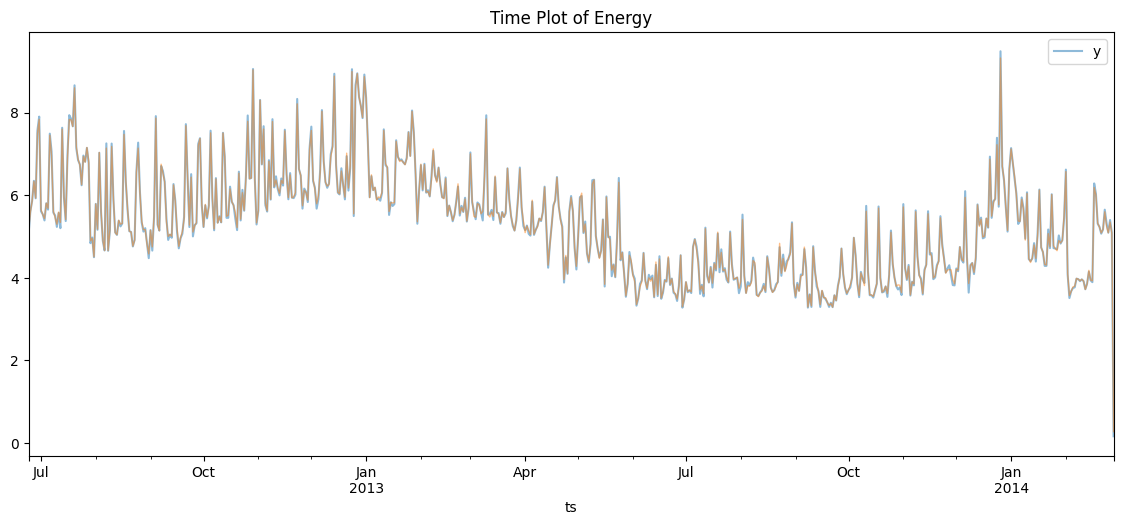

In [196]:
ax = y.plot(alpha=0.5, figsize=(14, 5.5))
#ax = y_pred["y_pred"].plot(ax=ax, linewidth=1, alpha=0.5)
ax = y_pred["y_pred_boosted"].plot(ax=ax, linewidth=1, alpha=0.5)
ax.set_title("Time Plot of Energy")
plt.show()